### Modelo de ML. Primera versión.

Antes que nada, cabe destacar que el conjunto de datos contiene determinados atributos que, de introducirse en el modelo, provocarían un 'data leakage'. Dicho de otra manera, se estarían introduciendo datos que realmente no estarían disponibles en el momento de hacer la predicción. 

Nos referimos principalmente a la variable 'score', que incluye el resultado del partido, y a la variable 'minutes', que indica la duración del partido, pero también a los atributos que hacen referencia al rendimiento de los jugadores durante el partido (como 'w_ace, w_df, etc.). Teniendo en cuenta que estos últimos representan una parte muy importante de la base de datos y que realmente no determinan qué jugador ha ganado el partido, sino que solamente dan información sobre su nivel de juego, se ha optado por hacer dos versiones del conjunto de datos para entrenar los modelos con el objetivo de comparar los resultados. En la práctica, lo ideal sería incluir datos sobre el rendimiento medio de los jugadores en partidos pasados, de esta manera el modelo tendría más información sobre el nivel de juego de los jugadores y no se produciría ningún data leakage.

Así pues, en esta primera versión se incluirán los atributos relativos al rendimiento de los jugadores durante el partido, y en la segunda no. 

In [3]:
import pandas as pd
import numpy as np
from random import seed
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, mean_squared_error as mse
from joblib import dump

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('clean_data.csv')
df.head(5)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,...,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,loser_rank,year
0,0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,101723,Magnus Larsson,...,95.0,62.0,44.0,23.0,16.0,6.0,8.0,56.0,2.0,1990
1,1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,100946,Slobodan Zivojinovic,...,84.0,41.0,35.0,27.0,15.0,1.0,2.0,304.0,75.0,1990
2,2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,101234,Patrik Kuhnen,...,60.0,37.0,22.0,6.0,8.0,4.0,8.0,82.0,69.0,1990
3,3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,101889,Todd Woodbridge,...,74.0,45.0,30.0,11.0,10.0,5.0,8.0,50.0,84.0,1990
4,4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,101274,Udo Riglewski,...,77.0,41.0,28.0,15.0,11.0,4.0,8.0,88.0,28.0,1990


Primero, eliminamos las variables 'score' y 'minutes'.

In [5]:
df.drop(['Unnamed: 0', 'score', 'minutes'], axis=1, inplace=True)

In [6]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_name',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'best_of', 'round',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'loser_rank', 'year'],
      dtype='object')

Asimismo, vemos que la tabla identifica a los jugadores como Winner y Loser, por lo que para el modelo sería muy obvio quien gana el partido. Es por esto que aleatoriamente asignaremos el número 1 o 2 a todos los jugadores, creando un label que sea 1, cuando el jugador 1 gane el partido, y 0 cuando gane el jugador 2.

In [7]:
from random import seed
from random import randint

def assign_players(row):
    random_number = randint(1, 2)
    if random_number == 1:
        return (
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'],
            row['w_ace'], row['w_df'], row['w_svpt'], row['w_1stIn'], row['w_1stWon'], row['w_2ndWon'], row['w_SvGms'],
            row['w_bpSaved'], row['w_bpFaced'], row['winner_rank'],
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'],
            row['l_ace'], row['l_df'], row['l_svpt'], row['l_1stIn'], row['l_1stWon'], row['l_2ndWon'], row['l_SvGms'],
            row['l_bpSaved'], row['l_bpFaced'], row['loser_rank']
        )
    else:
        return (
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'],
            row['l_ace'], row['l_df'], row['l_svpt'], row['l_1stIn'], row['l_1stWon'], row['l_2ndWon'], row['l_SvGms'],
            row['l_bpSaved'], row['l_bpFaced'], row['loser_rank'],
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'],
            row['w_ace'], row['w_df'], row['w_svpt'], row['w_1stIn'], row['w_1stWon'], row['w_2ndWon'], row['w_SvGms'],
            row['w_bpSaved'], row['w_bpFaced'], row['winner_rank']
        )

def create_player_columns(df):
    df[['Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht', 'Player1_ioc', 'Player1_age',
        'Player1_ace', 'Player1_df', 'Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms',
        'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank',
        'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht', 'Player2_ioc', 'Player2_age',
        'Player2_ace', 'Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms',
        'Player2_bpSaved', 'Player2_bpFaced', 'Player2_rank']] = df.apply(assign_players, axis=1, result_type='expand')
    return df

def create_label(df):
    return 1 if df['winner_id'] == df['Player1_id'] else 0

def df_preprocessing(df):
    df = create_player_columns(df)
    df['label'] = df.apply(create_label, axis=1)
    df.drop(columns=['winner_id', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'w_ace', 'w_df',
                     'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'loser_id',
                     'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'l_ace', 'l_df', 'l_svpt',
                     'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank'],
            inplace=True)
    return df

df = df_preprocessing(df)
df.head(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,year,...,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,3,R32,1990,...,3.0,95.0,62.0,44.0,23.0,16.0,6.0,8.0,2.0,1
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,3,R32,1990,...,2.0,84.0,41.0,35.0,27.0,15.0,1.0,2.0,75.0,1
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,3,R32,1990,...,2.0,60.0,37.0,22.0,6.0,8.0,4.0,8.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,3,R32,1990,...,0.0,60.0,40.0,30.0,14.0,9.0,3.0,3.0,50.0,0
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,3,R32,1990,...,2.0,77.0,41.0,28.0,15.0,11.0,4.0,8.0,28.0,1


Estudiamos la correlación entre las variables y con el label.

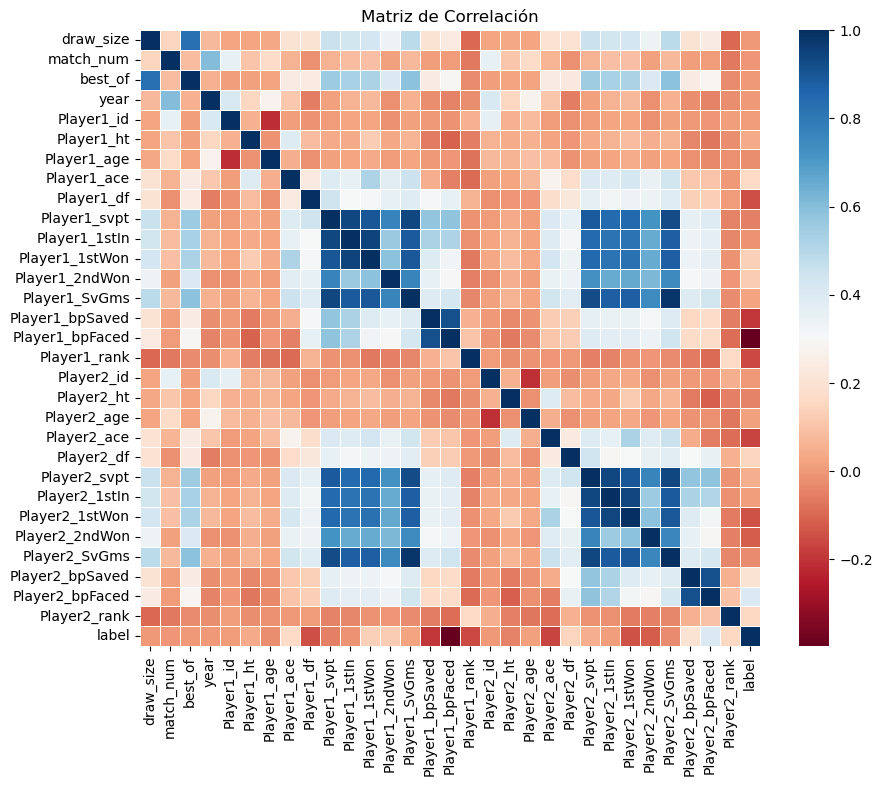

In [8]:
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según tus preferencias
sns.heatmap(df.corr(), cmap="RdBu", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

In [9]:
df.corr()['label'].sort_values()

Player1_bpFaced   -0.396505
Player1_bpSaved   -0.195052
Player2_ace       -0.169633
Player1_rank      -0.159626
Player1_df        -0.148252
Player2_1stWon    -0.142212
Player2_2ndWon    -0.121279
Player1_svpt      -0.049260
Player2_ht        -0.044099
Player2_SvGms     -0.027025
Player1_age       -0.024978
Player1_1stIn     -0.013517
match_num         -0.004266
best_of           -0.003129
year              -0.000748
draw_size          0.000114
Player2_id         0.001404
Player1_id         0.005714
Player2_1stIn      0.008993
Player2_age        0.013388
Player1_SvGms      0.021261
Player1_ht         0.038522
Player2_svpt       0.046836
Player1_2ndWon     0.122530
Player1_1stWon     0.135781
Player2_df         0.147792
Player2_rank       0.159119
Player1_ace        0.161206
Player2_bpSaved    0.200505
Player2_bpFaced    0.401818
label              1.000000
Name: label, dtype: float64

Vemos que los atributos con mayor correlación con el 'label' son aquellos relacionados con los puntos de rotura (break points), los aces, el ranking de los jugadores y los servicios. Tiene sentido por cuanto: 
- los puntos de rotura son puntos decisivos en el partido,
- es coherente que a mejor posición en el ranking, más probable sea que el jugador gane, y
- la eficiencia del servicio tiene un fuerte impacto en el partido, ya que puede llevar a un punto de rotura o a un juego de servicio.

In [10]:
df.shape

(94344, 43)

In [11]:
df.duplicated().sum()

0

In [12]:
df['label'].unique()

array([1, 0])

In [13]:
dump(df, 'datos.df')

['datos.df']

### EDA de los datos para entrenar el modelo

<Figure size 800x500 with 0 Axes>

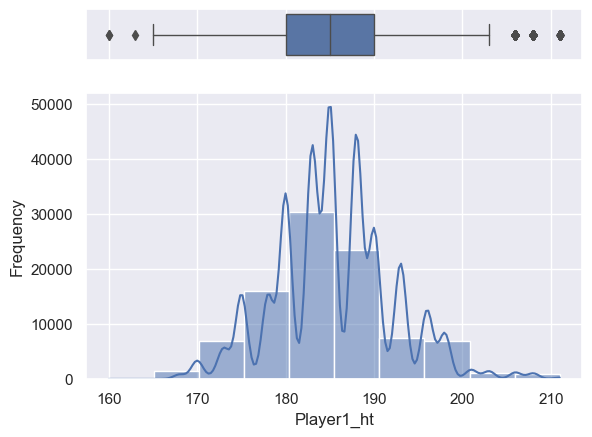

<Figure size 800x500 with 0 Axes>

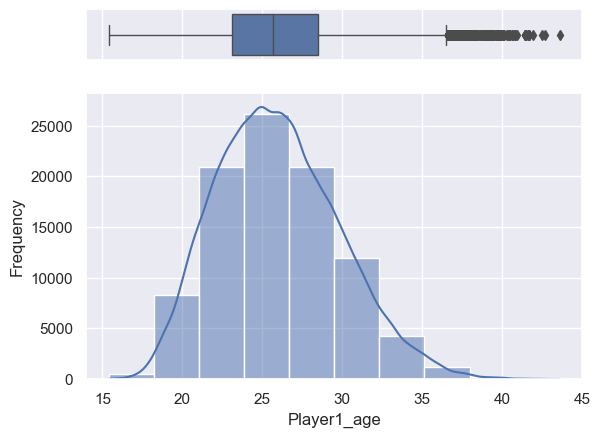

<Figure size 800x500 with 0 Axes>

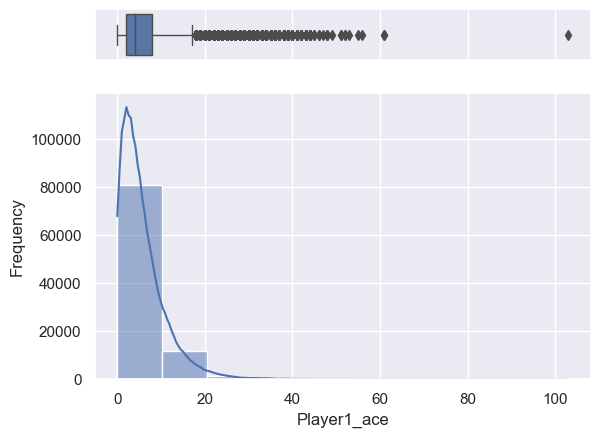

<Figure size 800x500 with 0 Axes>

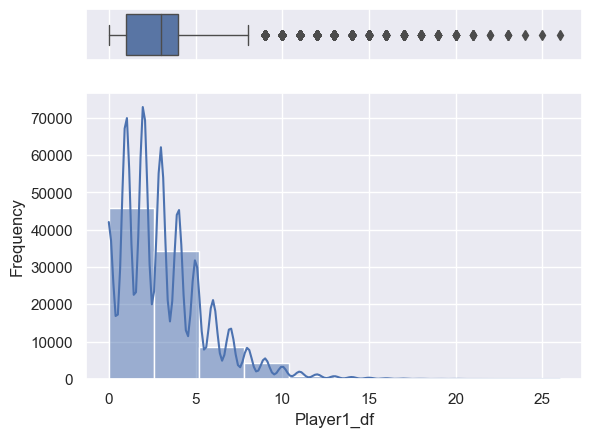

<Figure size 800x500 with 0 Axes>

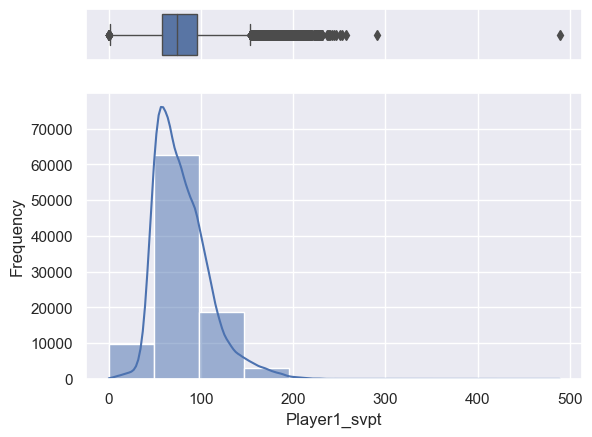

<Figure size 800x500 with 0 Axes>

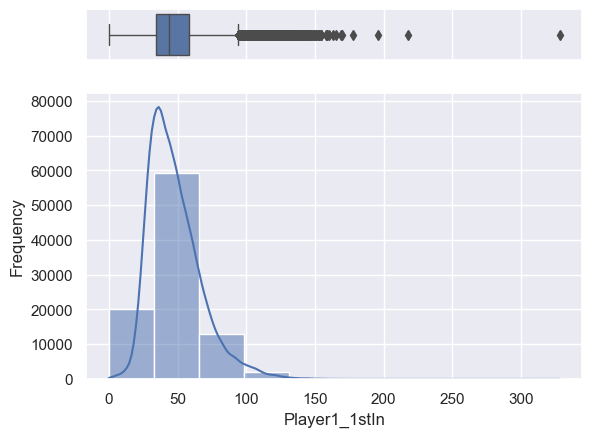

<Figure size 800x500 with 0 Axes>

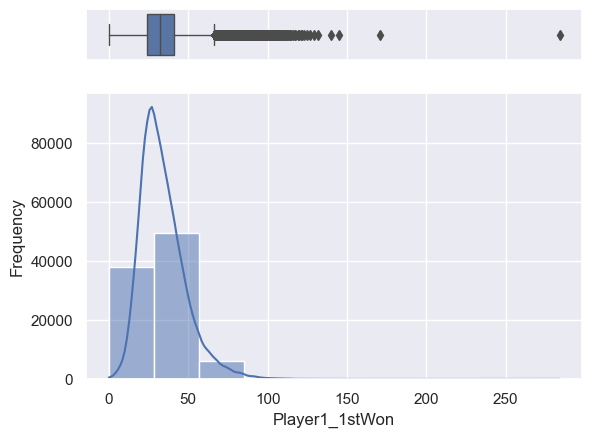

<Figure size 800x500 with 0 Axes>

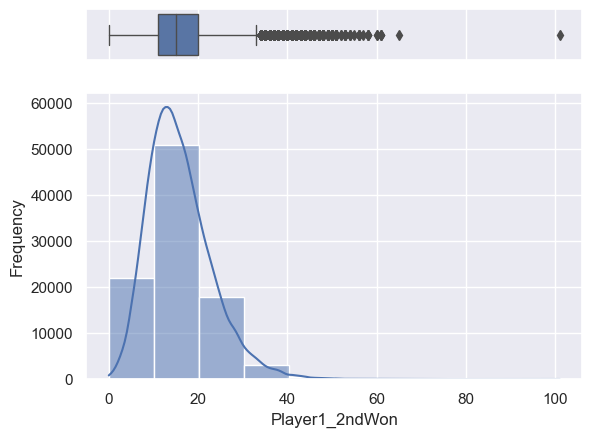

<Figure size 800x500 with 0 Axes>

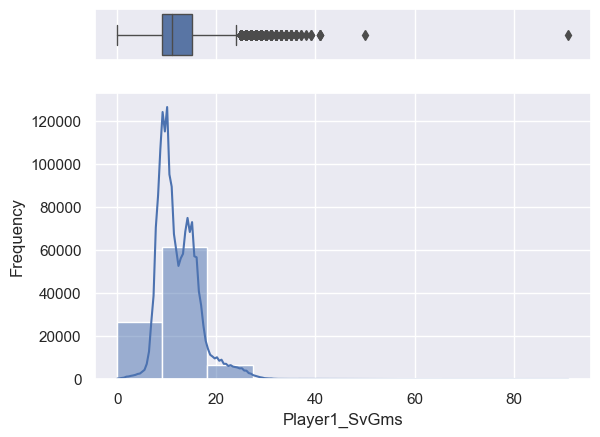

<Figure size 800x500 with 0 Axes>

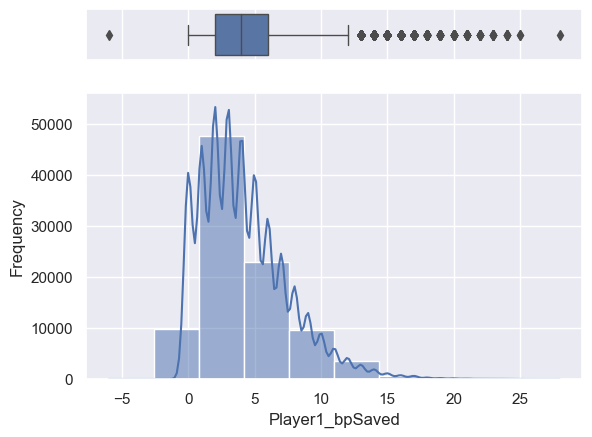

<Figure size 800x500 with 0 Axes>

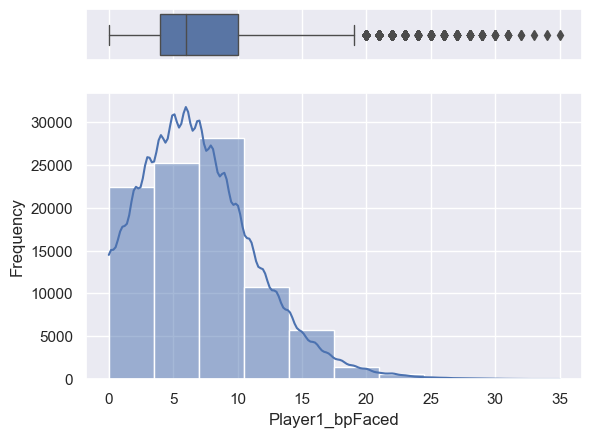

<Figure size 800x500 with 0 Axes>

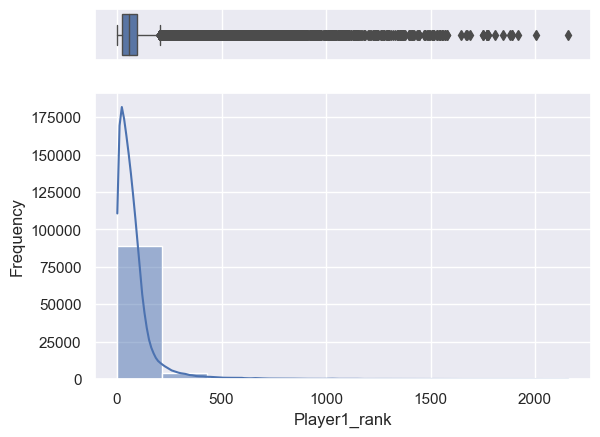

<Figure size 800x500 with 0 Axes>

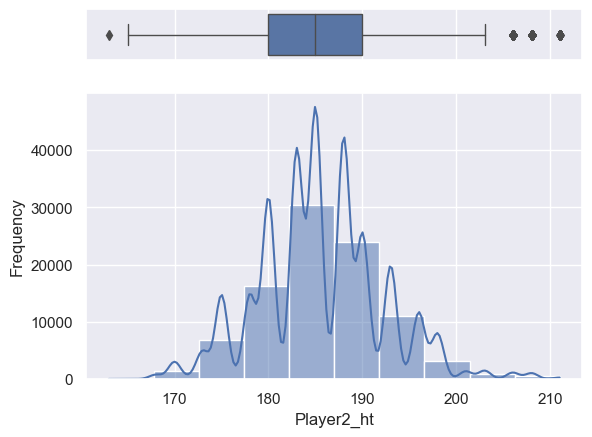

<Figure size 800x500 with 0 Axes>

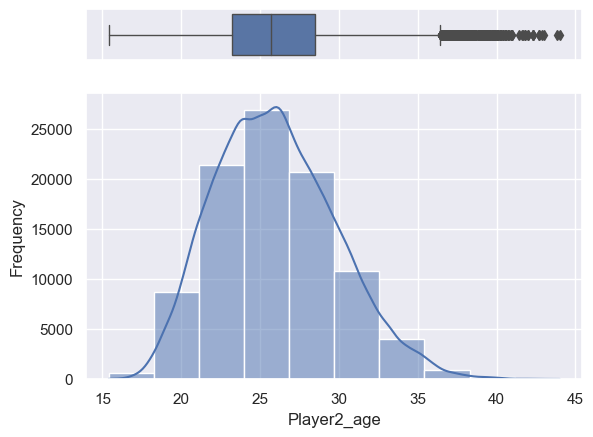

<Figure size 800x500 with 0 Axes>

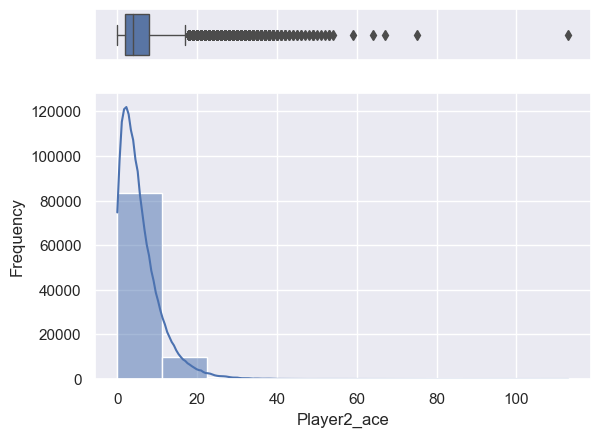

<Figure size 800x500 with 0 Axes>

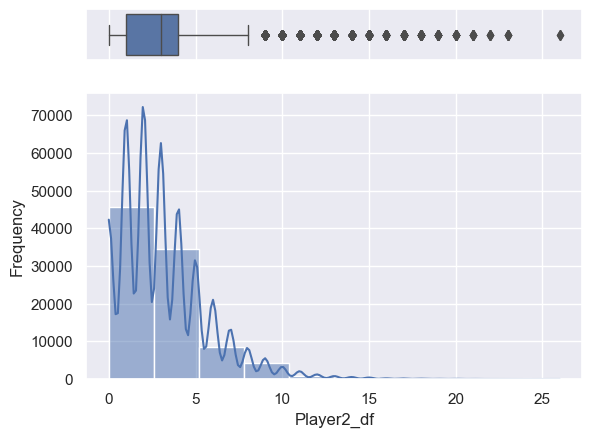

<Figure size 800x500 with 0 Axes>

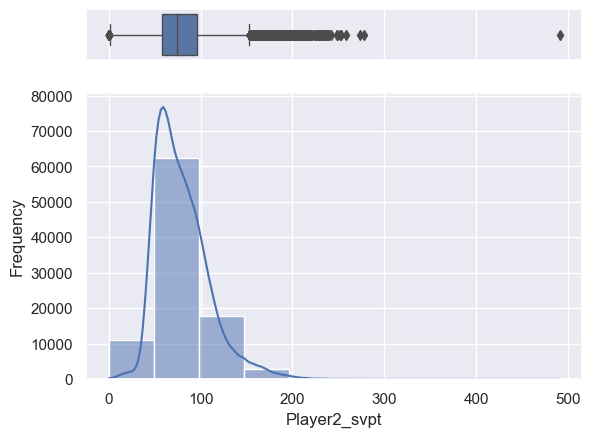

<Figure size 800x500 with 0 Axes>

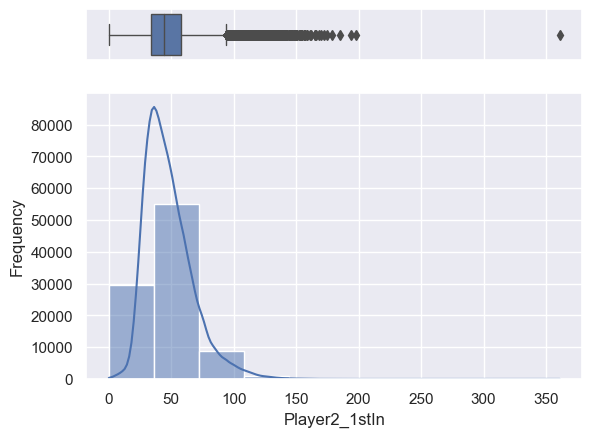

<Figure size 800x500 with 0 Axes>

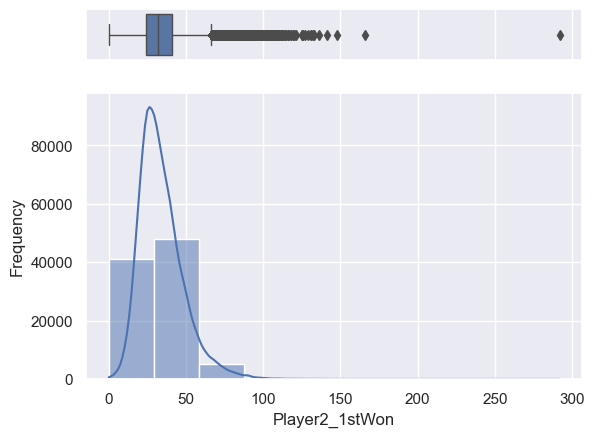

<Figure size 800x500 with 0 Axes>

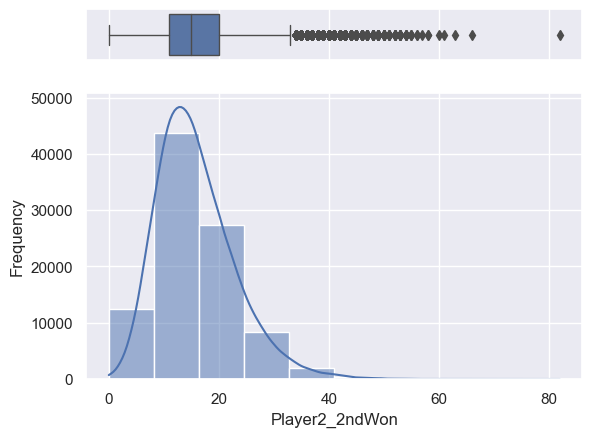

<Figure size 800x500 with 0 Axes>

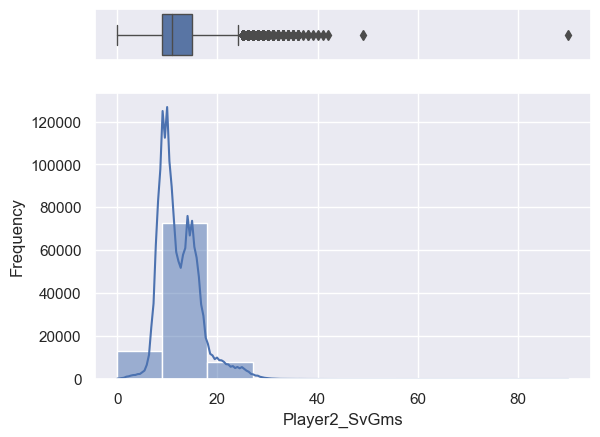

<Figure size 800x500 with 0 Axes>

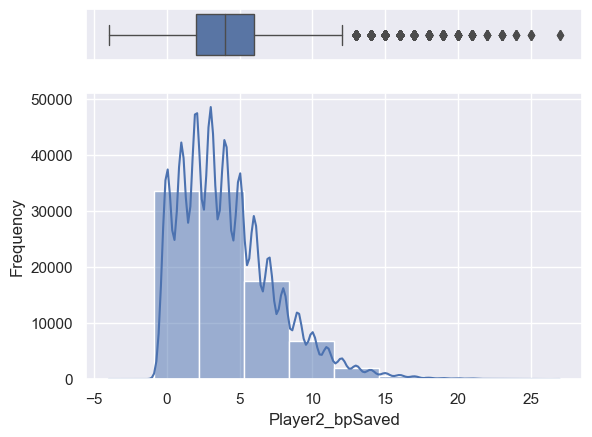

<Figure size 800x500 with 0 Axes>

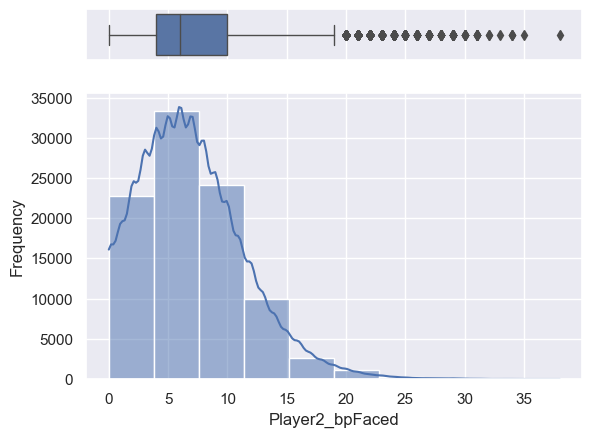

<Figure size 800x500 with 0 Axes>

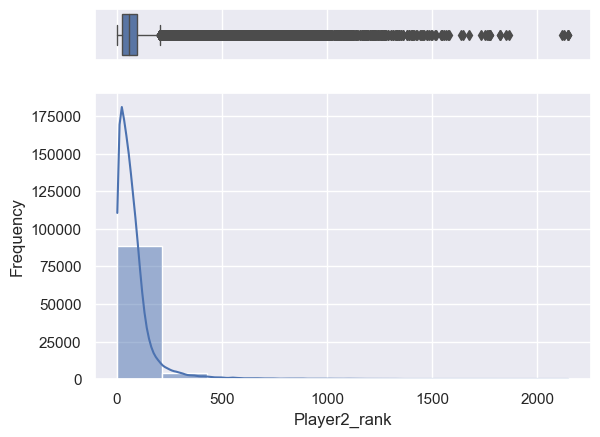

In [14]:
numerical_features = ['Player1_ht', 'Player1_age', 'Player1_ace', 'Player1_df','Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank', 'Player2_ht', 'Player2_age', 'Player2_ace','Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms', 'Player2_bpSaved','Player2_bpFaced', 'Player2_rank']

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.set()
    
    filtered_data = df[df[i].notna()]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

Vemos que las variables 'Player1_ht' y 'Player2_ht' tienen una distribución normal, y el resto no son normales y tienen outliers. Por tanto, aplicaremos StandardScaler() a las primeras y el RobustScaler() a las segundas.

### Transformaciones

#### Variables numéricas

Hemos visto que ninguna tiene una distribución normal y que todas tienen outliers.

In [15]:
numeric_features = ['Player1_ht', 'Player2_ht']
numeric_transformer = Pipeline(
    steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

numeric_features_out = ['Player1_age', 'Player1_ace', 'Player1_df','Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank', 'Player2_age', 'Player2_ace','Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms', 'Player2_bpSaved','Player2_bpFaced', 'Player2_rank']
numeric_transformer_out = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

#### Variables categóricas

Aplicaremos la técnica OneHotEncoding a todas las variables ya que tienen más de dos valores.

In [16]:
categorical_features = ['surface', 'tourney_level', 'round', 'Player1_hand', 'Player2_hand']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(sparse=False))
    ]
)

#### Pipeline

Aplicamos las transformaciones anteriores al conjunto de datos con el ColumnTransformer(). Este Pipeline es el que aplicaremos cuando hagamos los modelos.

In [17]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_out', numeric_transformer_out, numeric_features_out) 
    ],
    remainder = 'drop'
)

In [18]:
preprocessor

ColumnTransformer(transformers=[('categoricals',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['surface', 'tourney_level', 'round',
                                  'Player1_hand', 'Player2_hand']),
                                ('numericals',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Player1_ht'...
                                 ['Player1_age', 'Player1_ace', 'Player1_df',
                                  'Player1_svpt', 'Player1_1stIn',
                                  'Player1_1stWon', 'Player1_2ndWon',
                                  'Player1_SvGms', 'Player1_bpSaved',
                                  'Player1_bpFaced', 'Player1_rank',
                                  'Player2_age', 'Player2_ace', 'Player2_df',
                                  'Player2_svpt', 'Player2_1stIn',
                                  'Player2_1stWon', 'Player2_2ndWon',
                                  'Player2_SvGms', 'Player2_bpSaved',
                                  'Player2_bpFaced', 'Player2_rank'])])

### Train y Test

In [19]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,year,...,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,3,R32,1990,...,3.0,95.0,62.0,44.0,23.0,16.0,6.0,8.0,2.0,1
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,3,R32,1990,...,2.0,84.0,41.0,35.0,27.0,15.0,1.0,2.0,75.0,1
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,3,R32,1990,...,2.0,60.0,37.0,22.0,6.0,8.0,4.0,8.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,3,R32,1990,...,0.0,60.0,40.0,30.0,14.0,9.0,3.0,3.0,50.0,0
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,3,R32,1990,...,2.0,77.0,41.0,28.0,15.0,11.0,4.0,8.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94339,2023-0605,Tour Finals,Hard,8,A,2023-11-13,290,3,RR,2023,...,0.0,47.0,34.0,32.0,8.0,10.0,0.0,0.0,2.0,0
94340,2023-0605,Tour Finals,Hard,8,A,2023-11-13,289,3,RR,2023,...,2.0,92.0,64.0,47.0,15.0,15.0,5.0,8.0,2.0,1
94341,2023-0605,Tour Finals,Hard,8,A,2023-11-13,288,3,RR,2023,...,2.0,68.0,45.0,28.0,9.0,9.0,7.0,10.0,5.0,1
94342,2023-0605,Tour Finals,Hard,8,A,2023-11-13,287,3,RR,2023,...,2.0,70.0,51.0,40.0,10.0,11.0,3.0,4.0,3.0,0


In [20]:
X = df.drop('label', axis=1)
y = df['label']

In [21]:
y.value_counts()

0    47200
1    47144
Name: label, dtype: int64

Vemos que el 'label' está balanceado, no hace falta aplicar técnicas de balanceo.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,year,...,Player2_ace,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank
8875,1993-423,Los Angeles,Hard,32,A,1993-08-02,11,3,R32,1993,...,4.0,5.0,101.0,58.0,34.0,21.0,13.0,10.0,15.0,70.0
20017,1997-339,Adelaide,Hard,32,A,1996-12-30,2,3,R32,1996,...,10.0,3.0,46.0,25.0,21.0,9.0,9.0,1.0,3.0,73.0
34590,2001-560,US Open,Hard,128,G,2001-08-27,10,5,R128,2001,...,27.0,12.0,134.0,61.0,46.0,38.0,19.0,6.0,11.0,96.0
75413,2016-0315,Newport,Grass,32,A,2016-07-11,293,3,R16,2016,...,6.0,3.0,59.0,34.0,27.0,14.0,9.0,3.0,3.0,25.0
29454,2000-314,Gstaad,Clay,32,A,2000-07-10,28,3,QF,2000,...,2.0,1.0,79.0,49.0,34.0,18.0,11.0,4.0,5.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1992-457,Taipei,Carpet,32,A,1992-10-19,21,3,R16,1992,...,6.0,2.0,43.0,21.0,20.0,13.0,8.0,2.0,2.0,96.0
54886,2008-747,Beijing,Hard,28,A,2008-09-22,19,3,R16,2008,...,2.0,0.0,60.0,36.0,28.0,15.0,11.0,1.0,2.0,48.0
76820,2017-M-DC-2017-WG-M-BEL-GER-01,Davis Cup WG R1: BEL vs GER,Hard,4,D,2017-02-03,2,5,RR,2017,...,2.0,1.0,91.0,62.0,39.0,15.0,14.0,7.0,11.0,143.0
860,1991-425,Barcelona,Clay,56,A,1991-04-08,32,3,R32,1991,...,1.0,0.0,97.0,63.0,44.0,18.0,16.0,5.0,8.0,53.0


In [24]:
rfc = RandomForestClassifier(random_state = 42)

pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [25]:
pipeline.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

R2 score: 0.90


In [26]:
pipeline.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['surface', 'tourney_level',
                                                   'round', 'Player1_hand',
                                                   'Player2_hand']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',...
                                                   'Player1_df', 'Player1_svpt',
                                                   'Player1_1stIn',
                                                   'Player1_1stWon',
                                                   'Player1_2ndWon',
                                                   'Player1_SvGms',
                                                   'Player1_bpSaved',
                                                   'Player1_bpFaced',
                                                   'Player1_rank',
                                                   'Player2_age', 'Player2_ace',
                                                   'Player2_df', 'Player2_svpt',
                                                   'Player2_1stIn',
                                                   'Player2_1stWon',
                                                   'Player2_2ndWon',
                                                   'Player2_SvGms',
                                                   'Player2_bpSaved',
                                                   'Player2_bpFaced',
                                                   'Player2_rank'])])),
                ('model', RandomForestClassifier(random_state=42))])

Miramos otros modelos:

In [28]:
lda = LinearDiscriminantAnalysis()
knc = KNeighborsClassifier()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression(random_state=42)

In [29]:
modelos = {
    'lda': lda,
    'knc': knc,
    'gnb' : gnb,
    'dtc' : dtc,
    'svc' : svc,
    'rfc' : rfc,
    'lr' : lr
}

In [30]:
data_y = {}
metrics = []

for name, model in modelos.items():
    pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', model)
        ])
    pipeline.fit(X_train, y_train)
     
    data_y[name] = pipeline.predict(X_test)

    metrics.append({
        'Modelo': name,
        'Score': pipeline.score(X_test, y_test)
    })

df_y = pd.DataFrame(data_y)
df_metrics = pd.DataFrame(metrics)

In [31]:
df_y['y_test'] = y_test.reset_index(drop=True)

In [32]:
df_y

,lda,knc,gnb,dtc,svc,rfc,lr,y_test
0,1,1,0,1,1,1,1,1
1,1,1,0,1,1,1,1,1
2,1,0,0,1,1,1,1,1
3,1,0,0,1,1,1,1,1
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18864,1,1,0,1,1,1,1,1
18865,1,1,0,1,1,1,1,1
18866,1,1,0,1,1,1,1,1
18867,1,1,0,1,1,1,1,0


In [33]:
df_metrics

,Modelo,Score
0,lda,0.951296
1,knc,0.798293
2,gnb,0.542742
3,dtc,0.861943
4,svc,0.947957
5,rfc,0.896656
6,lr,0.952515


In [34]:
dump(df_metrics, 'df_metrics.df')

['df_metrics.df']

Text(0, 0.5, 'Densidad')

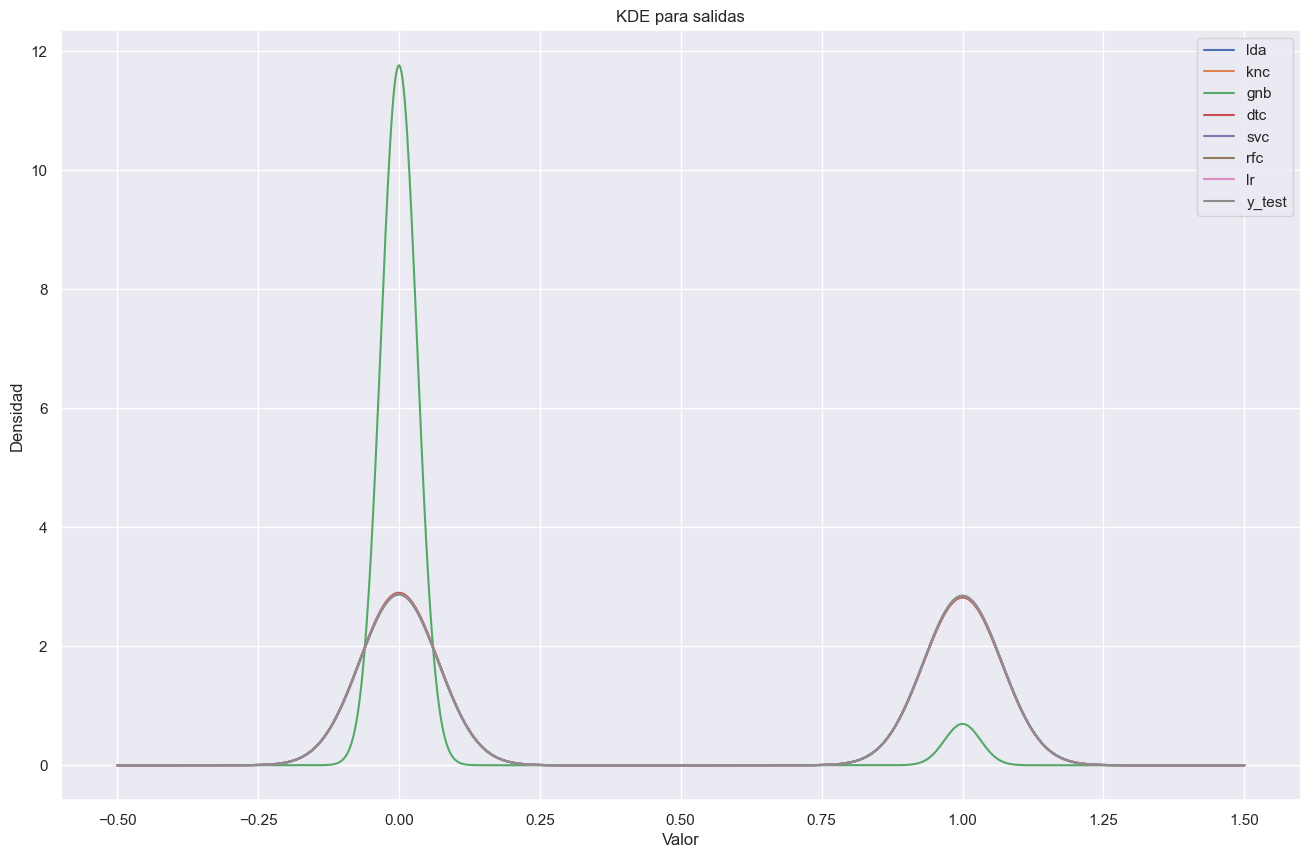

In [35]:
fig, ax = plt.subplots(figsize=(16, 10))
df_y.plot.kde(ax=ax)
plt.title('KDE para salidas')
plt.xlabel('Valor')
plt.ylabel('Densidad')

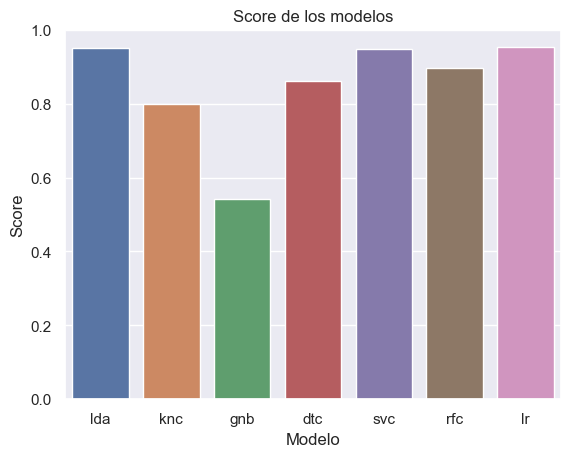

In [36]:
sns.barplot(data=df_metrics, x = 'Modelo', y = 'Score')
plt.title('Score de los modelos');

Vemos que los modelos tienen un buen score, excepto el modelo gnb (Gaussian Naïve Bayes). Ello puede deberse a que este modelo no se ajuste bien al conjunto de datos o que tenga un sesgo específico en sus predicciones, que resulta en la concentración de la curva en ciertos valores. 

Los 3 modelos con un mayor score son: lda (Linear Discriminant Analysis), svc (Support Vector Classifier) y lr (Logistic Regression). 

### Evaluación de los modelos

In [37]:
evaluation = pd.DataFrame({'model':['lda','knc','gnb','dtc','svc','rfc','lr']})

In [38]:
from sklearn.model_selection import cross_val_score

models = [lda, knc, gnb, dtc, svc, rfc, lr]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    X_array = X.values if isinstance(X, pd.DataFrame) else X

    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    print(score)
    score_mean.append(np.nanmean(score)) 
    score_std.append(np.nanstd(score))

[0.95075878 0.95406323        nan 0.95202756        nan]
[0.79682708 0.79474496        nan 0.7991703         nan]
[0.04941831 0.18118137        nan 0.11893276        nan]
[0.86570007 0.86574615        nan 0.87158006        nan]
[0.94760844 0.94840112        nan 0.94694525        nan]
[0.90609854 0.90259188        nan 0.90527209        nan]
[0.95112383 0.95386084        nan 0.9530728         nan]


In [39]:
evaluation['f1_cv'] = score_mean
evaluation['f1_std_cv'] = score_std
evaluation

,model,f1_cv,f1_std_cv
0,lda,0.952283,0.001361
1,knc,0.796914,0.001808
2,gnb,0.116511,0.053819
3,dtc,0.867675,0.002761
4,svc,0.947652,0.000595
5,rfc,0.904654,0.001497
6,lr,0.952686,0.001150


Seleccionamos el mejor modelo y buscamos sus mejores hiperparámetros:

In [40]:
pipeline_LR = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(0.99)),
        ('model', LogisticRegression(random_state=42))
    ]
)

params_LR = {
    'model__penalty': ['l2', 'elasticnet'],
    'model__warm_start': [True, False],
    'model__random_state': [42]
}

gs_LR = GridSearchCV(pipeline_LR, params_LR, cv = 5, scoring = ['f1', 'accuracy'], refit = 'f1', n_jobs = -1)

gs_LR.fit(X, y)

best_model_LR = gs_LR.best_estimator_

print(f'Best parameter set: {gs_LR.best_params_}\n')
print(f'Scores: {classification_report(y, gs_LR.predict(X))}')

/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarn

Best parameter set: {'model__penalty': 'l2', 'model__random_state': 42, 'model__warm_start': True}

Scores:               precision    recall  f1-score   support

           0       0.89      0.89      0.89     47200
           1       0.89      0.89      0.89     47144

    accuracy                           0.89     94344
   macro avg       0.89      0.89      0.89     94344
weighted avg       0.89      0.89      0.89     94344



Hacemos una matriz de confusión del mejor modelo:

Accuracy score: 0.89


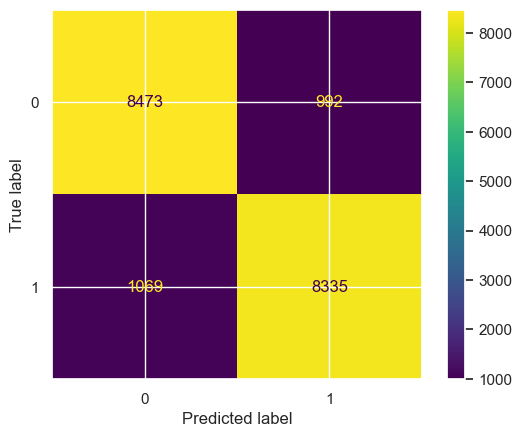

In [41]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model_LR.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(best_model_LR.score(X_test, y_test)))

y_pred = best_model_LR.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [42]:
df_y['y_pred_best'] = y_pred

In [43]:
dump(df_y, 'df_y.df')

['df_y.df']

#### Predicciones

In [44]:
X_new = pd.DataFrame([['1991-339', 'Adelaide', 'Hard', 32, 'A', '1990-12-31', 1, 3, 'R32', 130.0, 1990, 101723, 'Magnus Larsson', 'R', 193.0, 'SWE', 20.7, 6.0, 2.0, 96.0, 55.0, 39.0, 25.0, 15.0, 2.0, 4.0, 56.0, 101414, 'Boris Becker', 'R', 190.0, 'GER', 23.1, 8.0, 3.0, 95.0, 62.0, 44.0, 23.0, 16.0, 6.0, 8.0, 2.0]],
                     columns= [['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'best_of', 'round', 'minutes', 'year',
       'Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht',
       'Player1_ioc', 'Player1_age', 'Player1_ace', 'Player1_df',
       'Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon',
       'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank',
       'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht',
       'Player2_ioc', 'Player2_age', 'Player2_ace', 'Player2_df',
       'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon',
       'Player2_SvGms', 'Player2_bpSaved', 'Player2_bpFaced', 'Player2_rank']])

y_new = best_model_LR.predict(X_new)
y_new

array([1])

In [45]:
dump(best_model_LR, 'best_model.joblib')

['best_model.joblib']